In [1]:
import torch
import numpy as np
# from plot_manager import PlotManager
from dataset import build_dataloaders
from bilstm import BiLSTMAttentionClassifier
# from attention_inspector import AttentionInspector

# ai
import torch
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal
from scipy.stats import spearmanr
from collections import defaultdict
from scipy.stats import chi2_contingency
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
# eof ai

# pm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
# eof pm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttentionClassifier(
    pc_vocab=9,
    acc_vocab=10,
    oct_vocab=7,
    dur_vocab=33,
    meas_vocab=4,
    emb_dim=32,
    lstm_hidden=128,
    num_classes=12,
    dropout=0.3
)
model.to(device)
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print("Loaded best model from epoch:", checkpoint["epoch"])

_, _, _, test_loader = build_dataloaders(
    "vocab.pkl", "dataset.pkl", batch_size=8)

Loaded best model from epoch: 15


In [3]:
class AttentionInspector:
    def __init__(self, device, model, dataloader):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        # makam
        self.makam_vocab = {
            "hicaz": 0, "nihavent": 1, "ussak": 2, "rast": 3,
            "huzzam": 4, "segah": 5, "huseyni": 6, "mahur": 7,
            "hicazkar": 8, "kurdilihicazkar": 9, "muhayyer": 10, "saba": 11
        }
        self.makam_vocab_inv = {v: k for k, v in self.makam_vocab.items()}
        # PC
        self.pc_vocab = {
            "PAD": 0, "Rest": 1,
            "G": 2, "A": 3, "B": 4, "C": 5, "D": 6, "E": 7, "F": 8
        }
        self.pc_vocab_inv = {v: k for k, v in self.pc_vocab.items()}
        # Acc
        self.acc_vocab = {"PAD": 0, "": 1,
                          "#1": 2, "#2": 3, "#3": 4, "#4": 5, "#5": 6, "#6": 7, "#7": 8, "#8": 9}
        self.acc_vocab_inv = {v: k for k, v in self.acc_vocab.items()}
        # Dur
        self.dur_vocab = {"PAD": 0,
                          0.007812: 1, 0.008929: 2, 0.010417: 3, 0.015625: 4, 0.017857: 5,
                          0.020833: 6, 0.025: 7, 0.027778: 8, 0.03125: 9, 0.035714: 10,
                          0.041667: 11, 0.05: 12, 0.055556: 13, 0.0625: 14, 0.071429: 15,
                          0.083333: 16, 0.1: 17, 0.111111: 18, 0.125: 19, 0.142857: 20,
                          0.166667: 21, 0.1875: 22, 0.2: 23, 0.222222: 24, 0.25: 25,
                          0.3: 26, 0.333333: 27, 0.375: 28, 0.4: 29, 0.5: 30, 0.666667: 31, 1.0: 32}
        self.dur_vocab_inv = {v: k for k, v in self.dur_vocab.items()}

    @torch.no_grad()
    def get_predictions(self):
        self.model.eval()

        (self.all_labels,
         self.all_preds,
         self.all_f_names,
         self.all_attn_weights,
         self.all_true_lengths,
         self.all_pcs,
         self.all_accs,
         self.all_meas,
         self.all_durs) = ([], [], [], [], [], [], [], [], [])

        for batch in self.dataloader:
            f_names = batch["f_names"]
            lengths = batch["lengths"]
            batch["accs"]
            batch["meas"]
            batch = {k: v.to(self.device)
                     for k, v in batch.items() if k != "f_names"}
            logits, attn_weights = self.model(batch)
            labels = batch["labels"]
            preds = torch.argmax(logits, dim=1)

            self.all_preds.append(preds.cpu().numpy())
            self.all_labels.append(labels.cpu().numpy())
            self.all_f_names.append(f_names)
            self.all_attn_weights.extend(attn_weights.cpu().numpy())
            self.all_true_lengths.append(lengths.cpu().numpy())
            self.all_pcs.extend(batch["pcs"].cpu().numpy())
            self.all_accs.extend(batch["accs"].cpu().numpy())
            self.all_meas.extend(batch["meas"].cpu().numpy())
            self.all_durs.extend(batch["durs"].cpu().numpy())

        self.all_preds = np.concatenate(self.all_preds)
        self.all_labels = np.concatenate(self.all_labels)
        self.all_f_names = np.concatenate(self.all_f_names)
        self.all_true_lengths = np.concatenate(self.all_true_lengths)

        return (
            self.all_labels,
            self.all_preds,
            self.all_f_names,
            self.all_attn_weights,
            self.all_true_lengths,
            self.all_pcs,
            self.all_accs,
            self.all_meas,
            self.all_durs
        )

    def export_vocabs(self):
        return (
            self.makam_vocab,
            self.makam_vocab_inv,
            self.pc_vocab,
            self.pc_vocab_inv,
            self.acc_vocab,
            self.acc_vocab_inv,
            self.dur_vocab,
            self.dur_vocab_inv
        )

    def evaluate_classification(self, y_true, y_pred, makam_names):
        results = {}

        # Overall accuracy
        results["accuracy"] = accuracy_score(y_true, y_pred)

        # Precision, Recall, F1 per class
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true,
            y_pred,
            average=None
        )

        # Macro & weighted
        results["macro_f1"] = np.mean(f1)
        results["weighted_f1"] = precision_recall_fscore_support(
            y_true,
            y_pred,
            average="weighted"
        )[2]

        # Confusion matrix
        results["confusion_matrix"] = confusion_matrix(y_true, y_pred)

        report = classification_report(
            y_true,
            y_pred,
            target_names=makam_names,
            digits=4,
            output_dict=True
        )
        results["report"] = report
        return results

    def get_single_piece_ai(self, piece_idx):
        # all_labels, all_preds, all_f_names, all_attn_weights, all_true_lengths
        true_len = self.all_true_lengths[piece_idx]

        attn_piece = self.all_attn_weights[piece_idx][:true_len]
        pcs_piece = self.all_pcs[piece_idx][:true_len]
        accs_piece = self.all_accs[piece_idx][:true_len]
        meas_piece = self.all_meas[piece_idx][:true_len]
        durs_piece = self.all_durs[piece_idx][:true_len]
        return (
            attn_piece,
            pcs_piece,
            accs_piece,
            meas_piece,
            durs_piece
        )

    def combine_pitch_pc_acc(self, pc_idx, acc_idx):
        pc = self.pc_vocab_inv.get(pc_idx, "UNK")
        acc_name = self.acc_vocab_inv.get(acc_idx, "natural")

        if pc == "PAD":
            return "PAD"
        if pc == "Rest":
            return "Rest"

        return f"{pc}{acc_name}"

    def aggregate_attention_by_pitch(self, attn, pitch_ids):
        """
        attn: (L,)
        pcs:  (L,) pitch class ids
        """
        agg = defaultdict(float)
        for a, p in zip(attn, pitch_ids):
            agg[p] += a
        return agg

    def aggregate_attention_by_pitch_acc(self, attn, pcs, accs):
        """
        attn: (L,)
        pcs:  (L,) pitch class ids
        accs: (L,) accidental ids
        """
        agg = defaultdict(float)

        for a, pc, acc in zip(attn, pcs, accs):
            if pc == 0:  # PAD
                continue
            agg[(pc, acc)] += float(a)

        return agg

    def normalize_attention(self, agg_dict):
        total = sum(agg_dict.values())
        return {k: v / total for k, v in agg_dict.items()}

    def aggregate_attention_pitch_acc_duration(self, attn, pcs, accs, durs):
        agg = defaultdict(float)

        for a, pc, acc, dur in zip(attn, pcs, accs, durs):
            if pc == 0:  # PAD
                continue
            dur_ratio = self.dur_vocab_inv[dur]
            agg[(pc, acc)] += float(a * dur_ratio)

        return agg

    def attention_duration_correlation(self, attn, durs):
        attn_arr = []
        dur_arr = []
        for a, d in zip(attn, durs):
            dur_ratio = self.dur_vocab_inv[d]
            dur_arr.append(dur_ratio)
            attn_arr.append(a)

        return spearmanr(attn, durs).correlation

    def get_makam_pieces(self, makam_id, correct=True):
        """
        {'hicaz': 0, 'nihavent': 1, 'ussak': 2, 'rast': 3,
        'huzzam': 4, 'segah': 5, 'huseyni': 6, 'mahur': 7,
        'hicazkar': 8, 'kurdilihicazkar': 9, 'muhayyer': 10, 'saba': 11}
        """
        res = []
        for i, (y_hat, y) in enumerate(zip(self.all_preds, self.all_labels)):
            if y != makam_id:
                continue
            if correct and y_hat == y:
                res.append(i)
            if not correct and y_hat != y:
                res.append(i)
        return np.array(res)

    def aggregate_attention_for_makam(self, makam_idx):
        num_pieces = len(self.all_pcs)
        makam_agg = defaultdict(float)
        piece_count = 0

        for i in range(num_pieces):
            if self.all_labels[i] != makam_idx:
                continue

            true_len = self.all_true_lengths[i]
            attn_piece = self.all_attn_weights[i][:true_len]
            pcs_piece = self.all_pcs[i][:true_len]
            accs_piece = self.all_accs[i][:true_len]

            piece_agg = self.aggregate_attention_by_pitch_acc(
                attn_piece, pcs_piece, accs_piece
            )

            for k, v in piece_agg.items():
                makam_agg[k] += v

            piece_count += 1

        return makam_agg, piece_count

    def aggregate_attention_correct_vs_incorrect(self, makam_idx):
        agg_correct = defaultdict(float)
        agg_incorrect = defaultdict(float)

        count_correct = 0
        count_incorrect = 0

        num_pieces = len(self.all_pcs)
        for i in range(num_pieces):
            if self.all_labels[i] != makam_idx:
                continue

            true_len = self.all_true_lengths[i]
            attn_piece = self.all_attn_weights[i][:true_len]
            pcs_piece = self.all_pcs[i][:true_len]
            accs_piece = self.all_accs[i][:true_len]

            piece_agg = self.aggregate_attention_by_pitch_acc(
                attn_piece, pcs_piece, accs_piece
            )

            if self.all_preds[i] == self.all_labels[i]:
                for k, v in piece_agg.items():
                    agg_correct[k] += v
                count_correct += 1
            else:
                for k, v in piece_agg.items():
                    agg_incorrect[k] += v
                count_incorrect += 1

        return agg_correct, agg_incorrect, count_correct, count_incorrect

    def attention_entropy(self, attn_dict):
        p = np.array(list(attn_dict.values()))
        return -np.sum(p * np.log(p + 1e-9))

    def get_mean_attn_dur_correlation_makam(self, makam):
        corrs = []
        makam_idx = self.get_makam_pieces(self.makam_vocab[makam])
        for idx in makam_idx:
            true_len_i = self.all_true_lengths[idx]
            attn_piece_i = self.all_attn_weights[idx][:true_len_i]
            durs_piece_i = self.all_durs[idx][:true_len_i]
            corr_i = self.attention_duration_correlation(
                attn_piece_i, durs_piece_i)
            corrs.append(corr_i)

        return np.array(corrs).mean()

    def get_mean_attn_dur_correlation_all(self):
        corrs = []
        num_pieces = len(self.all_pcs)
        for idx in range(num_pieces):
            true_len_i = self.all_true_lengths[idx]
            attn_piece_i = self.all_attn_weights[idx][:true_len_i]
            durs_piece_i = self.all_durs[idx][:true_len_i]
            corr_i = self.attention_duration_correlation(
                attn_piece_i, durs_piece_i)
            corrs.append(corr_i)
        return np.array(corrs).mean()

    def collect_attention_duration(self, target_makam=None):
        """
        Returns a pandas DataFrame with columns:
        ['duration', 'attention', 'makam']
        """
        records = []
        num_pieces = len(self.all_pcs)
        for i in range(num_pieces):
            makam_id = self.all_labels[i]
            makam_name = self.makam_vocab_inv[makam_id]

            if target_makam is not None and makam_name != target_makam:
                continue

            T = len(self.all_durs[i])
            for t in range(T):
                if t == self.all_true_lengths[i]:
                    break

                dur_id = self.all_durs[i][t]
                if dur_id == 0:
                    continue  # PAD

                dur_value = self.dur_vocab_inv[dur_id]
                if dur_value == 0:
                    continue  # ornaments

                attn = self.all_attn_weights[i][t]

                records.append({
                    "duration": dur_value,
                    "attention": attn,
                    "makam": makam_name
                })

        df = pd.DataFrame(records)
        df_binned = self.rebin_relative_duration(df)
        return df_binned

    def rebin_relative_duration(self, df):
        bins = [0.0, 0.0625, 0.1875, 0.375, 0.75, 1.01]
        labels = [
            "Very short (≤1/16)",
            "Short (≤3/16)",
            "Medium (≤3/8)",
            "Long (≤3/4)",
            "Very long (>3/4)"
        ]

        df = df.copy()
        df["dur_bin"] = pd.cut(
            df["duration"],
            bins=bins,
            labels=labels,
            include_lowest=True
        )
        return df

    def cliffs_delta(self, x, y):
        nx, ny = len(x), len(y)
        greater = sum(1 for xi in x for yi in y if xi > yi)
        less = sum(1 for xi in x for yi in y if xi < yi)
        return (greater - less) / (nx * ny)

    def collect_attn_dur_bin_stats(self, target_makam=None):
        df = self.collect_attention_duration(target_makam)
        # print(df.head())
        # pm.plot_attention_vs_duration_boxplot(df)

        # kruskal
        attention_by_bin = (
            df
            .groupby("dur_bin", observed=False)["attention"]
            .apply(list)
            .to_dict()
        )
        groups = [vals for vals in attention_by_bin.values() if len(vals) > 0]
        H, p = kruskal(*groups)
        print(f"Kruskal-Wallis H = {H:.3f}, p-value = {p:.4e}")

        print("- " * 30)

        # post hoc Holm
        # Prepare dataframe
        data = []
        for bin_name, vals in attention_by_bin.items():
            for v in vals:
                data.append({"duration_bin": bin_name, "attention": v})

        df_ph = pd.DataFrame(data)
        # print(df.head())

        # Dunn post-hoc with Holm correction
        dunn = sp.posthoc_dunn(
            df_ph,
            val_col="attention",
            group_col="duration_bin",
            p_adjust="holm"
        )

        print(dunn)

        print("- " * 30)

        # cliff's delta
        delta = self.cliffs_delta(
            attention_by_bin["Very short (≤1/16)"],
            attention_by_bin["Very long (>3/4)"]
        )

        print(f"Cliff's delta = {delta:.3f}")

        # chi^2
        threshold = np.percentile(df["attention"].to_numpy(), 95)

        def prob_high_attention(attentions):
            return np.mean(np.array(attentions) > threshold)

        for bin_name, vals in attention_by_bin.items():
            print(bin_name, prob_high_attention(vals))

        # Example: short vs long
        short = attention_by_bin["Very short (≤1/16)"]
        long = attention_by_bin["Very long (>3/4)"]

        table = [
            [sum(np.array(short) > threshold), sum(
                np.array(short) <= threshold)],
            [sum(np.array(long) > threshold),  sum(np.array(long) <= threshold)]
        ]

        chi2, p, _, _ = chi2_contingency(table)
        print(f"Chi² = {chi2:.3f}, p = {p:.4e}")

In [4]:
ai = AttentionInspector(device, model, test_loader)

In [5]:
(
    all_labels,
    all_preds,
    all_f_names,
    all_attn_weights,
    all_true_lengths,
    all_pcs,
    all_accs,
    all_meas,
    all_durs
) = ai.get_predictions()

In [6]:
(
    makam_vocab,
    makam_vocab_inv,
    pc_vocab,
    pc_vocab_inv,
    acc_vocab,
    acc_vocab_inv,
    dur_vocab,
    dur_vocab_inv
) = ai.export_vocabs()

In [7]:
makam_names = makam_vocab.keys()

In [8]:
list(makam_names)

['hicaz',
 'nihavent',
 'ussak',
 'rast',
 'huzzam',
 'segah',
 'huseyni',
 'mahur',
 'hicazkar',
 'kurdilihicazkar',
 'muhayyer',
 'saba']

In [21]:
results = ai.evaluate_classification(all_labels, all_preds, makam_names)

In [22]:
df = pd.DataFrame(data=results["report"])
print(df.T)
# df.T.to_excel("clf_report.xlsx")

                 precision    recall  f1-score     support
hicaz             1.000000  1.000000  1.000000   27.000000
nihavent          1.000000  1.000000  1.000000   18.000000
ussak             0.800000  0.857143  0.827586   14.000000
rast              0.923077  1.000000  0.960000   12.000000
huzzam            0.944444  1.000000  0.971429   17.000000
segah             0.954545  0.954545  0.954545   22.000000
huseyni           0.818182  0.818182  0.818182   11.000000
mahur             1.000000  0.947368  0.972973   19.000000
hicazkar          1.000000  1.000000  1.000000   11.000000
kurdilihicazkar   1.000000  1.000000  1.000000    6.000000
muhayyer          1.000000  0.777778  0.875000    9.000000
saba              1.000000  1.000000  1.000000    9.000000
accuracy          0.954286  0.954286  0.954286    0.954286
macro avg         0.953354  0.946251  0.948310  175.000000
weighted avg      0.956186  0.954286  0.954183  175.000000


In [23]:
results["confusion_matrix"]

array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]])

In [120]:
class PlotManager:
    def __init__(self):
        pass

    def plot_confusion_matrix(
        self,
        cm,
        class_names,
        title="Normalized Confusion Matrix",
        save_fig=False
    ):
        # Normalize row-wise
        cm = cm.astype(float)
        cm_norm = cm / cm.sum(axis=1, keepdims=True)

        plt.figure(figsize=(7, 6))
        sns.set_theme(style="white", font="Times")

        ax = sns.heatmap(
            cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            linewidths=0.5,
            linecolor="gray",
            cbar_kws={"label": "Proportion"},
            annot_kws={"size": 10}
        )

        ax.set_xlabel("Predicted Makam", fontsize=12)
        ax.set_ylabel("True Makam", fontsize=12)
        ax.figure.axes[-1].yaxis.label.set_size(12)
        ax.set_title(title, fontsize=12, pad=12)

        plt.xticks(rotation=90)
        plt.yticks(rotation=0)

        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/conf_matrix.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_attention_over_time(
            self,
            attn,
            title="Attention over Notes",
            save_fig=False
    ):
        plt.figure(figsize=(8, 3))
        plt.plot(attn, linewidth=2)
        plt.xlabel("Note Index", fontname="Times", fontsize=12)
        plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
        plt.title(title, fontname="Times", fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/attn_over_time.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_attention_with_pitch(
            self,
            attn,
            pcs,
            pc_vocab_inv,
            save_fig=False
    ):
        pitches = [pc_vocab_inv[p] for p in pcs]

        plt.figure(figsize=(24, 3))
        plt.bar(range(len(attn)), attn)
        plt.xticks(
            range(len(pitches)),
            pitches,
            rotation=90,
            fontsize=6,
            fontname="Times"
        )
        plt.xlabel("Note Index", fontname="Times", fontsize=12)
        plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
        plt.title("Attention Aligned with Pitch Classes",
                  fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/pitch_attn.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_attention_with_measures(
            self,
            attn,
            meas,
            title="Attention with Measure Boundaries",
            save_fig=False
    ):
        plt.figure(figsize=(8, 3))
        plt.plot(attn, linewidth=2)

        for i, m in enumerate(meas):
            if m == 3:  # measure end {'PAD': 0, 'start': 1, 'middle': 2, 'end': 3}
                plt.axvline(i, color="red", alpha=0.2)

        plt.xlabel("Note Index", fontname="Times", fontsize=12)
        plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
        plt.title(title, fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/meas_attn.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_attention_with_combined_pitch(
        self,
        attn,
        pcs,
        accs,
        ai: AttentionInspector,
        save_fig=False
    ):
        pitch_labels = [
            ai.combine_pitch_pc_acc(p, a)
            for p, a in zip(pcs, accs)
        ]

        plt.figure(figsize=(24, 3))
        plt.bar(range(len(attn)), attn)
        plt.xticks(
            range(len(pitch_labels)),
            pitch_labels,
            rotation=90,
            fontsize=6,
            fontname="Times"
        )
        plt.xlabel("Note Index", fontname="Times", fontsize=12)
        plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
        plt.title("Attention Aligned with Combined Pitch Classes",
                  fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig("comb_pitch_attn.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_agg_attention_by_pitch(
            self,
            agg,
            ai: AttentionInspector,
            title="Aggregated Attention by Pitch + Accidental",
            save_fig=False
    ):
        labels = []
        values = []

        for (pc, acc), val in sorted(agg.items(), key=lambda x: -x[1]):
            pc_name = ai.pc_vocab_inv[pc]
            acc_name = ai.acc_vocab_inv[acc]
            labels.append(f"{pc_name}{acc_name}")
            values.append(val)

        plt.figure(figsize=(5, 3))
        plt.bar(labels, values)
        plt.xticks(rotation=45, fontname="Times", fontsize=10)
        plt.ylabel("Total Attention", fontname="Times", fontsize=12)
        plt.title(title, fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/agg_attn_by_pitch_piece.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_agg_attention_by_pitch_duration(
            self,
            agg,
            ai: AttentionInspector,
            title="Duration Weighted Aggregated Attention by Pitch + Accidental",
            save_fig=False
    ):
        labels = []
        values = []

        for (pc, acc), val in sorted(agg.items(), key=lambda x: -x[1]):
            pc_name = ai.pc_vocab_inv[pc]
            acc_name = ai.acc_vocab_inv[acc]
            labels.append(f"{pc_name}{acc_name}")
            values.append(val)

        plt.figure(figsize=(5, 3))
        plt.bar(labels, values)
        plt.xticks(rotation=45, fontname="Times", fontsize=10)
        plt.ylabel("Total Attention", fontname="Times", fontsize=12)
        plt.title(title, fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig("figs/dur_weighted_agg_attn_by_pitch_piece.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_agg_attention_correct_vs_incorrect(
            self,
            makam,
            ai: AttentionInspector,
            save_fig=False
    ):
        agg_c, agg_i, n_c, n_i = ai.aggregate_attention_correct_vs_incorrect(
            ai.makam_vocab[makam])

        agg_c = ai.normalize_attention(agg_c)
        agg_i = ai.normalize_attention(agg_i)

        rows = []

        for key in set(agg_c.keys()).union(agg_i.keys()):
            pc, acc = key
            label = f"{ai.pc_vocab_inv[pc]}{ai.acc_vocab_inv[acc]}"

            rows.append({
                "Pitch": label,
                "Attention": agg_c.get(key, 0),
                "Type": "Correct"
            })
            rows.append({
                "Pitch": label,
                "Attention": agg_i.get(key, 0),
                "Type": "Incorrect"
            })
        df = pd.DataFrame(rows)
        plt.figure(figsize=(7, 3))
        sns.barplot(data=df, x="Pitch", y="Attention", hue="Type")
        plt.xticks(rotation=45, fontname="Times", fontsize=10)
        plt.title(
            f"Attention by Pitch+Accidental: "
            f"Correct vs Incorrect ({makam.capitalize()})",
            fontname="Times", fontsize=12
        )
        plt.tight_layout()
        if save_fig:
            plt.savefig(f"figs/attn_by_pitch_corr_incorr_{makam}.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

        entropy_correct = ai.attention_entropy(agg_c)
        entropy_incorrect = ai.attention_entropy(agg_i)

        print("Entropy (Correct):", entropy_correct)
        print("Entropy (Incorrect):", entropy_incorrect)

    def plot_agg_attention_by_pitch_duration_makam(
            self,
            makam,
            ai: AttentionInspector,
            title="Aggregated Attention by Pitch + Accidental",
            save_fig=False
    ):
        makam_agg, piece_count = ai.aggregate_attention_for_makam(
            ai.makam_vocab[makam])

        makam_agg = ai.normalize_attention(makam_agg)
        labels = []
        values = []

        for (pc, acc), val in sorted(
            makam_agg.items(), key=lambda x: -x[1]
        ):
            labels.append(f"{ai.pc_vocab_inv[pc]}{ai.acc_vocab_inv[acc]}")
            values.append(val)

        plt.figure(figsize=(4.5, 2.5))
        plt.bar(labels, values)
        plt.xticks(rotation=45, fontname="Times", fontsize=10)
        plt.title(title, fontname="Times", fontsize=12)
        plt.ylabel("Normalized Attention", fontname="Times", fontsize=12)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f"figs/attn_by_pitch_acc_makam_{makam}.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

    def plot_attention_vs_duration_boxplot(
            self,
            df,
            title=None,
            save_fig=False
    ):
        plt.figure(figsize=(8, 5))

        sns.boxplot(
            data=df,
            x="dur_bin",
            y="attention",
            color="skyblue",
            showfliers=False
        )

        # sns.stripplot(
        #     data=df,
        #     x="dur_bin",
        #     y="attention",
        #     color="black",
        #     size=2,
        #     alpha=0.25,
        #     jitter=True
        # )

        plt.xlabel("Relative duration (binned)",
                   fontname="Times", fontsize=12)
        plt.ylabel("Attention weight",
                   fontname="Times", fontsize=12)
        plt.title("Attention vs Relative Duration (Binned)",
                  fontname="Times", fontsize=12)
        plt.xticks(fontname="Times", fontsize=10)

        plt.tight_layout()
        if save_fig:
            plt.savefig("attn_vs_dur_box.pdf",
                        bbox_inches="tight", pad_inches=0.05)
        plt.show()

In [121]:
pm = PlotManager()

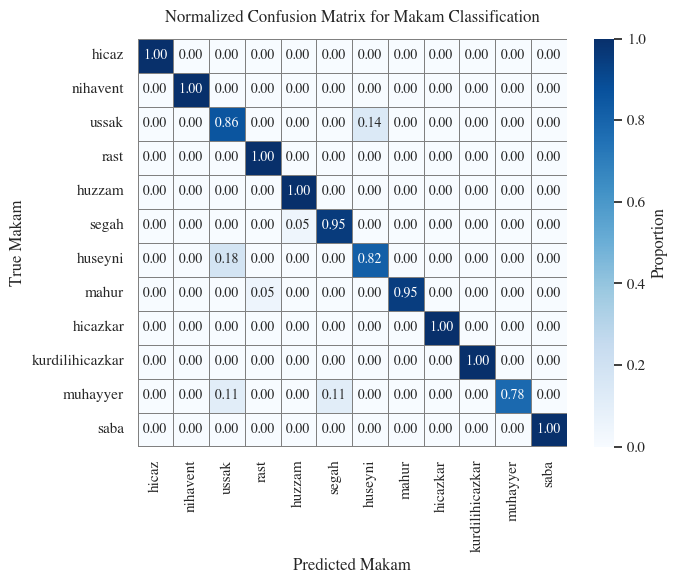

In [24]:
pm.plot_confusion_matrix(
    results["confusion_matrix"],
    makam_vocab.keys(),
    title="Normalized Confusion Matrix for Makam Classification",
    # save_fig=True
)

In [52]:
mn_list = list(makam_names)
for i, (l, p, t) in enumerate(zip(all_labels, all_preds, all_true_lengths)):
    if l == 0 and l == p:
        print(i, l, p, t, mn_list[l])

3 0 0 410 hicaz
4 0 0 405 hicaz
6 0 0 256 hicaz
18 0 0 626 hicaz
31 0 0 302 hicaz
41 0 0 680 hicaz
54 0 0 226 hicaz
70 0 0 98 hicaz
76 0 0 403 hicaz
80 0 0 704 hicaz
89 0 0 595 hicaz
95 0 0 22 hicaz
102 0 0 444 hicaz
105 0 0 610 hicaz
107 0 0 497 hicaz
108 0 0 482 hicaz
109 0 0 441 hicaz
113 0 0 698 hicaz
117 0 0 296 hicaz
123 0 0 521 hicaz
146 0 0 411 hicaz
149 0 0 328 hicaz
151 0 0 192 hicaz
153 0 0 497 hicaz
156 0 0 368 hicaz
161 0 0 426 hicaz
170 0 0 566 hicaz


In [98]:
# i = 6  # index of the piece in the test set
i = 18  # index of the piece in the test set

(
    attn_piece,
    pcs_piece,
    accs_piece,
    meas_piece,
    durs_piece
) = ai.get_single_piece_ai(i)

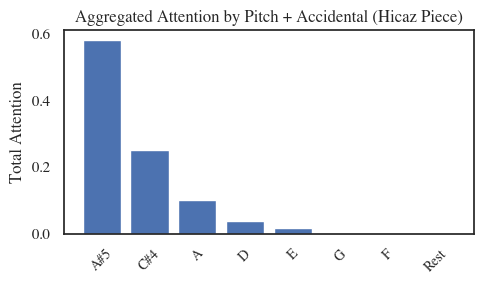

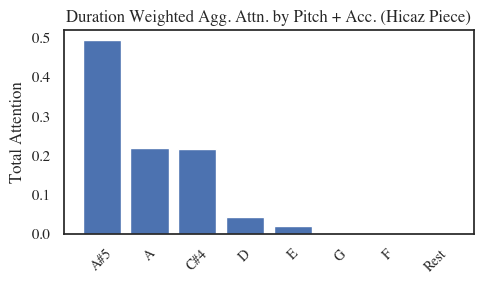

In [107]:
agg_pitch_acc = ai.aggregate_attention_by_pitch_acc(
    attn_piece, pcs_piece, accs_piece)
agg_pitch_acc = ai.normalize_attention(agg_pitch_acc)

pm.plot_agg_attention_by_pitch(
    agg_pitch_acc,
    ai,
    title="Aggregated Attention by Pitch + Accidental (Hicaz Piece)",
    save_fig=True
)

agg_duration = ai.aggregate_attention_pitch_acc_duration(
    attn_piece, pcs_piece, accs_piece, durs_piece
)
agg_duration = ai.normalize_attention(agg_duration)

pm.plot_agg_attention_by_pitch_duration(
    agg_duration,
    ai,
    title="Duration Weighted Agg. Attn. by Pitch + Acc. (Hicaz Piece)",
    save_fig=True
)

# makam = "hicaz"
# avg_corr = ai.get_mean_attn_dur_correlation_makam(makam)

# print(f"Attention-Duration correlation ({makam}): {avg_corr}")

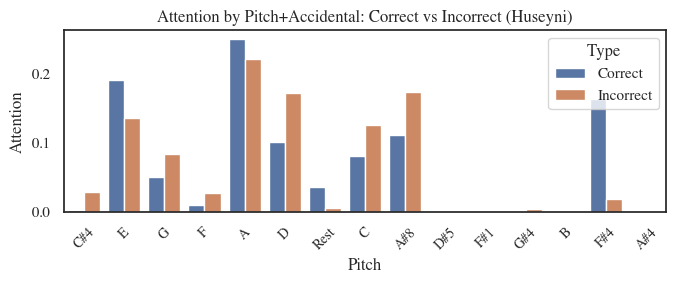

Entropy (Correct): 1.99711690407259
Entropy (Incorrect): 2.027367275992545


In [33]:
makam = "huseyni"
pm.plot_agg_attention_correct_vs_incorrect(makam, ai, save_fig=True)

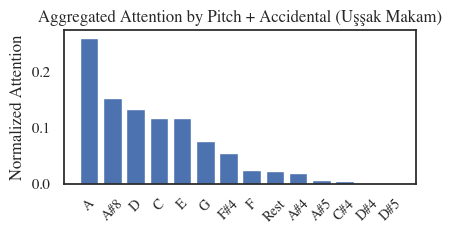

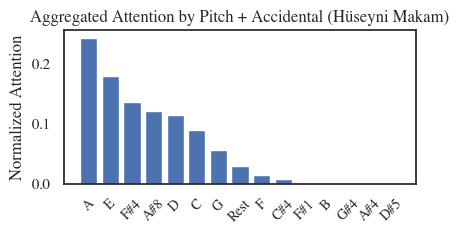

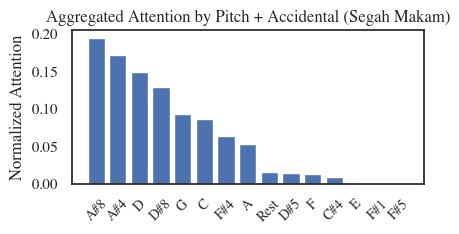

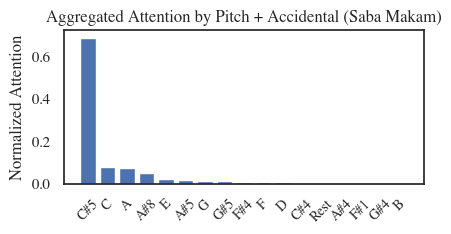

In [123]:
pm.plot_agg_attention_by_pitch_duration_makam(
    "ussak",
    ai,
    title="Aggregated Attention by Pitch + Accidental (Uşşak Makam)",
    save_fig=True
)
pm.plot_agg_attention_by_pitch_duration_makam(
    "huseyni",
    ai,
    title="Aggregated Attention by Pitch + Accidental (Hüseyni Makam)",
    save_fig=True
)
pm.plot_agg_attention_by_pitch_duration_makam(
    "segah",
    ai,
    title="Aggregated Attention by Pitch + Accidental (Segah Makam)",
    save_fig=True
)
pm.plot_agg_attention_by_pitch_duration_makam(
    "saba",
    ai,
    title="Aggregated Attention by Pitch + Accidental (Saba Makam)",
    save_fig=True
)

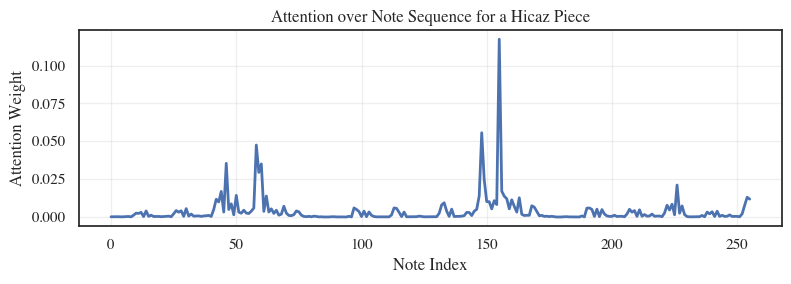

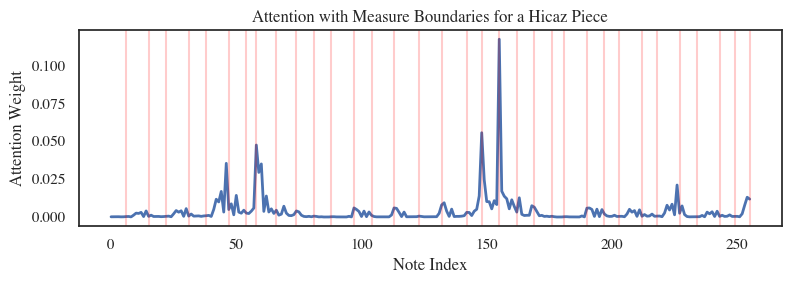

In [96]:
pm.plot_attention_over_time(
    attn_piece,
    title="Attention over Note Sequence for a Hicaz Piece",
    save_fig=True
)
# pm.plot_attention_with_pitch(
#     attn_piece,
#     pcs_piece,
#     pc_vocab_inv
# )
# pm.plot_attention_with_combined_pitch(
#     attn_piece,
#     pcs_piece,
#     accs_piece,
#     ai
# )
pm.plot_attention_with_measures(
    attn_piece,
    meas_piece,
    title="Attention with Measure Boundaries for a Hicaz Piece",
    save_fig=True
)